In [1]:
import datetime
import time

import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pgpasslib

from querymsc import WorkflowTools

In [2]:
connection_string = "postgresql+psycopg2://nannau@dbmsc.pcic.uvic.ca/msc"
engine = create_engine(connection_string)
Session = sessionmaker(bind=engine)
session = Session()

In [3]:
start_time = datetime.datetime(1990, 1, 1)
end_time = datetime.datetime(1991, 1, 1)

msc = WorkflowTools(start_time, end_time, month=1)

In [4]:
annual_tot_precip = msc.query_annual_precip(session)
annual_tot_rain = msc.query_annual_rain(session)

Year interval: 1.0
Year interval: 1.0


In [5]:
#start = time.time()
#df_tot_precip = pd.read_sql(annual_tot_precip.statement, engine)
#df_tot_rain = pd.read_sql(annual_tot_rain.statement, engine)
#end = time.time()
#print((end-start)/60., 'minutes', (end-start), 'seconds')

In [6]:
#df_tot_precip.sort_values(by=['lon', 'lat']).head()

In [7]:
#df_tot_rain.sort_values(by=['lon', 'lat']).head()

In [8]:
#df_vars = pd.read_sql(msc.query_variables(session).statement, engine)
#df_vars[df_vars['standard_name']=='lwe_thickness_of_precipitation_amount']

In [9]:
#df_vars[df_vars['standard_name'].str.contains('rain')]

In [10]:
df = pd.read_sql(msc.query_design_temp_1(session).statement, engine)

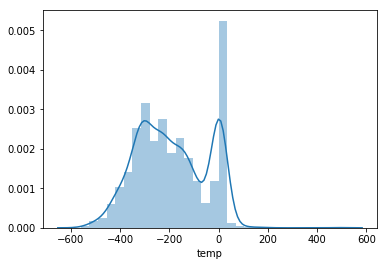

In [11]:
sns.distplot(df['temp'])

In [26]:
df_filt = df[df['obs_count'] > 50]

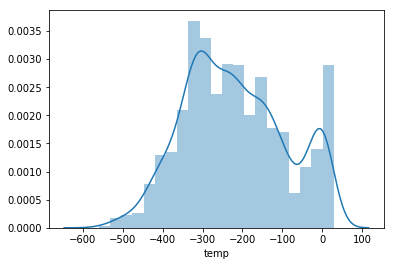

In [27]:
sns.distplot(df_filt['temp'])